<a href="https://colab.research.google.com/github/DanteNoguez/modelos/blob/main/notebooks/TinyVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import requests
import zipfile
from pathlib import Path

data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'
if image_path.is_dir():
  print('Already exists.')
else:
  print('Creating directory...')
  image_path.mkdir(parents=True, exist_ok=True)

Creating directory...


In [ ]:
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
  print('Downloading...')
  f.write(request.content)

with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
  print('Unzipping...')
  zip_ref.extractall(image_path)

Downloading...
Unzipping...


In [ ]:
import os
def walk_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

walk_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 58 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 46 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 46 images in data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 146 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 150 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 154 images in data/pizza_steak_sushi/train/pizza


In [ ]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

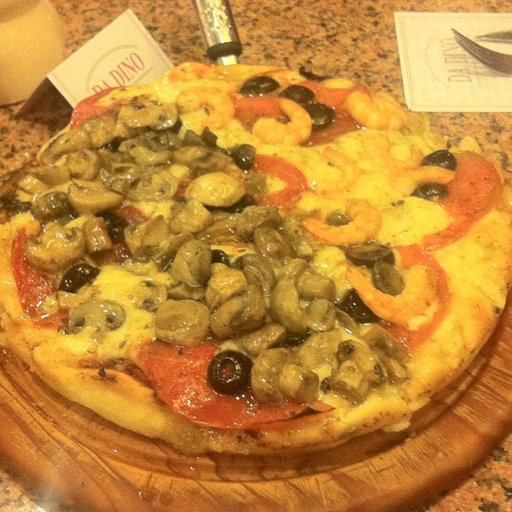

In [ ]:
import random
from PIL import Image

#random.seed(16)

image_path_list = list(image_path.glob('*/*/*.jpg'))

random_path = random.choice(image_path_list)

image_class = random_path.parent.stem

img = Image.open(random_path)

img

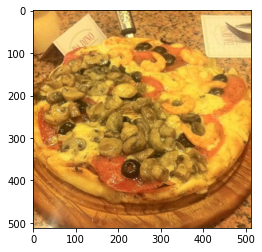

In [ ]:
image = np.array(img)
plt.imshow(image, cmap='gray')

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
data_transform = transforms.Compose([transforms.Resize(size=(64,64)),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.ToTensor()])

In [ ]:
tensor_img = data_transform(img)

In [ ]:
tensor_img.shape

torch.Size([3, 64, 64])

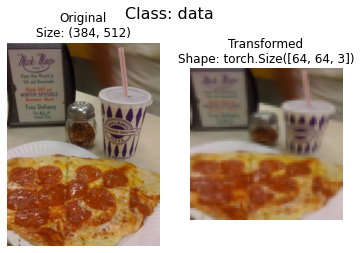

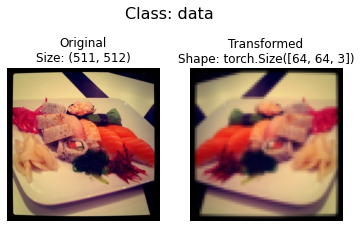

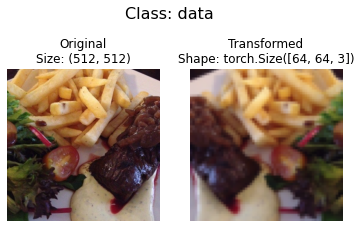

In [ ]:
def plot_img(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images and transforms them to plot them
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for path in random_image_paths:
    with Image.open(path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize: {f.size}')
      ax[0].axis(False)

      transformed_image = transform(f).permute(1, 2, 0) #From C,H,W -> H,W,C
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      ax[1].axis('off')

      fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

plot_img(image_paths=image_path_list, transform=data_transform, n=3)

In [ ]:
#Load images into tensors

from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

train_data

Dataset ImageFolder
    Number of datapoints: 450
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [ ]:
class_names = train_data.classes
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
img, label = train_data[0]
img.shape, img.dtype, label, type(label)

(torch.Size([3, 64, 64]), torch.float32, 0, int)

In [ ]:
img_permute = img.permute(1, 2, 0)

img.shape, img_permute.shape

(torch.Size([3, 64, 64]), torch.Size([64, 64, 3]))

Text(0.5, 1.0, 'pizza')

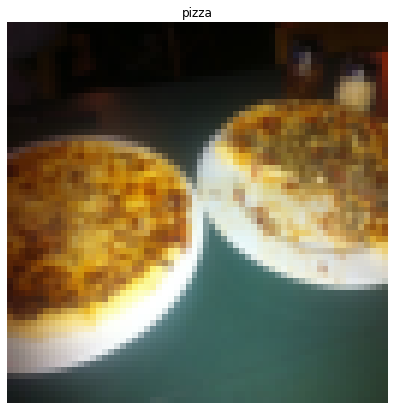

In [ ]:
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label])

In [ ]:
len(train_data)/8

56.25

In [ ]:
os.cpu_count()

2

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True)

test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=False)

In [ ]:
len(test_dataloader)

10

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape #NCHW

(torch.Size([16, 3, 64, 64]), torch.Size([16]))

## Loading image data with a custom `dataset`

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset
import pathlib
from PIL import Image
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
target_dir = train_dir

classes_found = sorted([entry.name for entry in list(os.scandir(target_dir))])

In [ ]:
classes_found

['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}")
  
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [ ]:
find_classes(target_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
#Replicating ImageFolder from PyTorch

class ImageFolderCustom(Dataset):
  def __init__(self, targ_dir: str, transform=None):
    self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int) -> Image.Image:
    """Opens an image via path and returns it"""
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    """returns len of samples"""
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    """Returns one sample of data and label (X, y)."""
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [ ]:
train_transforms = transforms.Compose([transforms.Resize(size=(64, 64)),
                                         transforms.RandomHorizontalFlip(p=0.5),
                                         transforms.ToTensor()])
  
test_transforms = transforms.Compose([transforms.Resize(size=(64,64)),
                                      transforms.ToTensor()])

In [ ]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir, transform=test_transforms)

In [ ]:
train_data.class_to_idx, train_data_custom.class_to_idx

({'pizza': 0, 'steak': 1, 'sushi': 2}, {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 9,
                          display_shape: bool=True,
                          seed: int = None):
  if n > 10:
    n = 10
    display_shape = False
    print("For display purposes, n shouldn't be higher than 10")
  
  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16, 8))

  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
    
    targ_image_adjust = targ_image.permute(1,2,0)

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis('off')
    if classes:
      title = f'Class: {classes[targ_label]}'
      if display_shape:
        title = title + f'\nshape: {targ_image_adjust.shape}'
    plt.title(title)

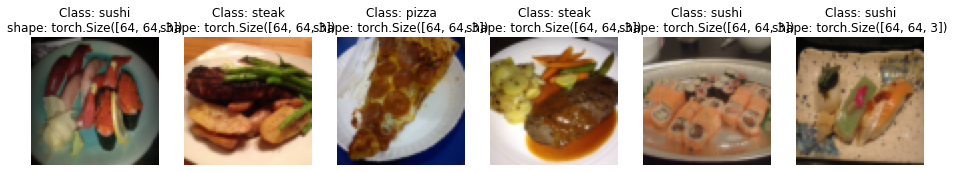

In [ ]:
display_random_images(train_data_custom, n=6, classes=class_names, seed=None)

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_custom_dataloader = DataLoader(dataset=train_data_custom, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True)

test_custom_dataloader = DataLoader(dataset=test_data_custom, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=False)

In [ ]:
len(test_custom_dataloader)

10

In [ ]:
img_custom, label_custom = next(iter(train_custom_dataloader))
img_custom.shape, label_custom.shape #NCHW

(torch.Size([16, 3, 64, 64]), torch.Size([16]))

In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                      transforms.RandAugment(),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor()])

In [ ]:
image_path_list = list(image_path.glob('*/*/*.jpg'))

image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/3138001.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/730464.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/289822.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2061929.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/399377.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2365038.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3553838.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3173402.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/670345.jpg')]

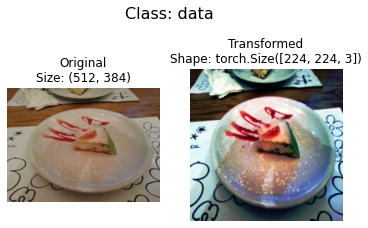

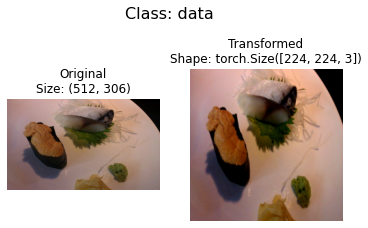

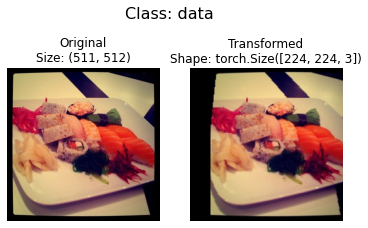

In [ ]:
plot_img(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None)

In [ ]:
 # MODEL

simple_transform = transforms.Compose([transforms.Resize(size=(64,64)),
                                       transforms.ToTensor()])


train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform, target_transform=None)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

train_data_simple

Dataset ImageFolder
    Number of datapoints: 450
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [ ]:
BATCH_SIZE = 32

train_dataloader_simple = DataLoader(dataset=train_data_simple, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), shuffle=False)

In [ ]:
train_dataloader_simple

In [ ]:
simple_img, simple_label = next(iter(train_dataloader_simple))
simple_img.shape, simple_label.shape #NCHW

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    
    self.conv_block3 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    
    self.classifier = nn.Sequential(
        nn.Flatten(start_dim=1, end_dim=-1),
        nn.Linear(hidden_units*4*4, output_shape, bias=True))

  def forward(self, x):
    #x = self.conv_block1(x)
    #x = self.conv_block2(x)
    #print(x.shape)
    #x = self.conv_block3(x)
    #print(x.shape)
    #x = self.classifier(x)
    #print(x.shape)
    return self.classifier(self.conv_block3(self.conv_block2(self.conv_block1(x))))

In [ ]:
simple_model = TinyVGG(input_shape=3, hidden_units=20, output_shape=len(class_names)).to(device)

In [ ]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
simple_model(image_batch.to(device))

tensor([[-0.0295,  0.0204, -0.0584],
        [-0.0303,  0.0208, -0.0579],
        [-0.0300,  0.0208, -0.0577],
        [-0.0300,  0.0209, -0.0591],
        [-0.0296,  0.0205, -0.0577],
        [-0.0297,  0.0214, -0.0574],
        [-0.0297,  0.0212, -0.0573],
        [-0.0298,  0.0210, -0.0574],
        [-0.0294,  0.0212, -0.0572],
        [-0.0293,  0.0206, -0.0571],
        [-0.0297,  0.0207, -0.0573],
        [-0.0302,  0.0207, -0.0572],
        [-0.0298,  0.0212, -0.0574],
        [-0.0298,  0.0214, -0.0575],
        [-0.0300,  0.0210, -0.0581],
        [-0.0294,  0.0215, -0.0576],
        [-0.0298,  0.0212, -0.0572],
        [-0.0300,  0.0212, -0.0574],
        [-0.0302,  0.0207, -0.0576],
        [-0.0297,  0.0210, -0.0583],
        [-0.0297,  0.0209, -0.0573],
        [-0.0301,  0.0204, -0.0582],
        [-0.0298,  0.0211, -0.0571],
        [-0.0292,  0.0210, -0.0573],
        [-0.0297,  0.0210, -0.0575],
        [-0.0295,  0.0206, -0.0578],
        [-0.0300,  0.0209, -0.0577],
 

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(simple_model, input_size=(1, 3, 64, 64))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 20, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 20, 62, 62]           560
│    └─ReLU: 2-2                         [1, 20, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 20, 60, 60]           3,620
│    └─ReLU: 2-4                         [1, 20, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 20, 30, 30]           --
├─Sequential: 1-2                        [1, 20, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 20, 28, 28]           3,620
│    └─ReLU: 2-7                         [1, 20, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 20, 26, 26]           3,620
│    └─ReLU: 2-9                         [1, 20, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 20, 13, 13]           --
├─Seq

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=simple_model.parameters(), lr=0.001)

In [ ]:
import requests
from pathlib import Path 

if Path('helper_functions.py').is_file():
  pass
else:
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

from helper_functions import accuracy_fn

In [ ]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

def train_time(start, end, device):
  total_time = end - start
  print(f'Train time on {device}: {total_time:.3f} seconds.')
  return total_time

def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, accuracy_fn, device):
  epoch_count = []
  loss_values = []
  test_loss_values = []
  
  model_time = timer()
  epochs = 100

  for epoch in tqdm(range(epochs)):
    #print(f'Epoch: {epoch}.')
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
      model.train()
      y_preds = model(X.to(device))
      loss = loss_fn(y_preds, y.to(device))
      train_loss += loss.item()
      train_acc += accuracy_fn(y.to(device), y_preds.argmax(dim=1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    if batch % 25 == 0:
      epoch_count.append(epoch)
      loss_values.append(loss)
      print(f'Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.')

  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      y_pred_test = model(X_test.to(device))
      test_loss += loss_fn(y_pred_test, y_test.to(device))
      test_acc += accuracy_fn(y_test.to(device), y_pred_test.argmax(dim=1))
      
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  print(f'Train loss: {train_loss:.4f}; Train acc: {train_acc:.4f}; test loss: {test_loss:.4f}; test acc: {test_acc:.4f}.')
  model_end_time = timer()
  train_time(model_time, model_end_time, device)

In [ ]:
def test_step(model, data_loader, loss_fn, accuracy_fn):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X_test, y_test in data_loader:
      y_pred_test = model(X_test.to(device))
      test_loss += loss_fn(y_pred_test, y_test.to(device))
      test_acc += accuracy_fn(y_test.to(device), y_pred_test.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
  print(f'Test loss:{test_loss:.4f}; Test acc: {test_acc:.4f}.')
  return test_loss, test_acc

In [ ]:
#train(simple_model, train_dataloader_simple, test_dataloader_simple, loss_fn, optimizer, accuracy_fn, device)

In [ ]:
#test_step(simple_model, test_dataloader, loss_fn, accuracy_fn)

In [ ]:
 # AUGMENTED MODEL

aug_transform = transforms.Compose([transforms.Resize(size=(64,64)),
                                    transforms.TrivialAugmentWide(),
                                    #transforms.RandomErasing(),
                                    transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                     transforms.ToTensor()])


train_data_aug = datasets.ImageFolder(root=train_dir, transform=aug_transform, target_transform=None)
test_data_aug = datasets.ImageFolder(root=test_dir, transform=test_transform)

In [ ]:
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=aug_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform)

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_augmented = DataLoader(train_data_augmented, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
aug_model = TinyVGG(input_shape=3, hidden_units=40, output_shape=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.Adam(params=aug_model.parameters(), lr=0.001, weight_decay=3e-05)

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)
  
  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader) 
  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0,  0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader): 
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train_2(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module,
          epochs: int = 100, 
          device=device):
  
  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  
  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    
    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  
  # 6. Return the filled results at the end of the epochs
  return results

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how mnay epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend() 

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

In [ ]:
model_aug = train_2(aug_model, train_dataloader_augmented, test_dataloader_simple, optimizer, loss_fn)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.0993 | Train acc: 0.3542 | Test loss: 1.0976 | Test acc: 0.3688
Epoch: 1 | Train loss: 1.0939 | Train acc: 0.3771 | Test loss: 1.0825 | Test acc: 0.4062
Epoch: 2 | Train loss: 1.0712 | Train acc: 0.4604 | Test loss: 1.0028 | Test acc: 0.5369
Epoch: 3 | Train loss: 1.0279 | Train acc: 0.4625 | Test loss: 1.0012 | Test acc: 0.4278
Epoch: 4 | Train loss: 1.0584 | Train acc: 0.4562 | Test loss: 0.9936 | Test acc: 0.5426
Epoch: 5 | Train loss: 1.0615 | Train acc: 0.4792 | Test loss: 0.9688 | Test acc: 0.5545
Epoch: 6 | Train loss: 1.0457 | Train acc: 0.5312 | Test loss: 1.0312 | Test acc: 0.5574
Epoch: 7 | Train loss: 1.0168 | Train acc: 0.5125 | Test loss: 1.0075 | Test acc: 0.5159
Epoch: 8 | Train loss: 1.0154 | Train acc: 0.4667 | Test loss: 0.9883 | Test acc: 0.5318
Epoch: 9 | Train loss: 1.0189 | Train acc: 0.5042 | Test loss: 1.0414 | Test acc: 0.4949
Epoch: 10 | Train loss: 0.9939 | Train acc: 0.5208 | Test loss: 0.9810 | Test acc: 0.5017
Epoch: 11 | Train lo

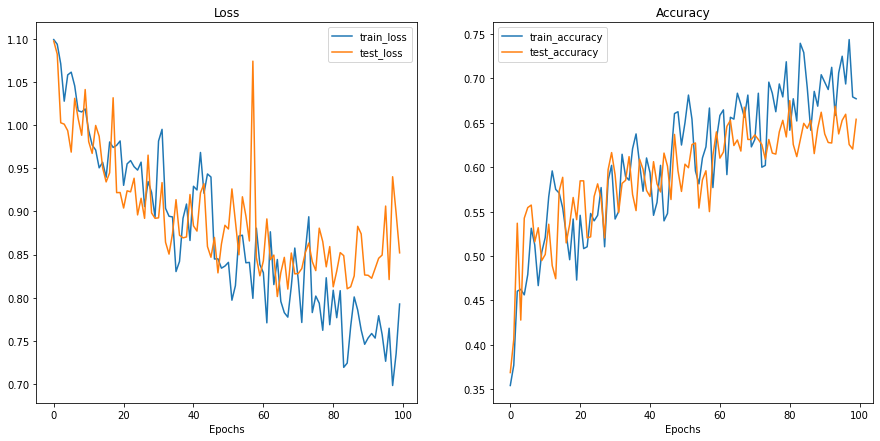

In [ ]:
plot_loss_curves(model_aug)

In [ ]:
custom_image = "carne.jpg"
with open("carne.jpg", "wb") as f:
  request = requests.get("https://raw.githubusercontent.com/DanteNoguez/intro-ai/main/img/carne.JPG")
  f.write(request.content)

In [ ]:
import torchvision
img_orig = torchvision.io.read_image(custom_image)

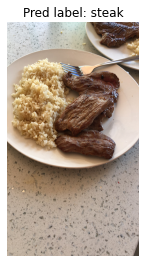

In [ ]:
aug_model.eval()
with torch.inference_mode():
  # Get image pixels into float + between 0 and 1
  img = img_orig / 255.

  # Resize image to 64x64
  resize = transforms.Resize((64, 64))
  img = resize(img)

  # Turn image in single batch and pass to target device
  batch = img.unsqueeze(0).to(device)

  # Predict on image
  y_pred_logit = aug_model(batch)

  # Convert pred logit to pred label
  # pred_label = torch.argmax(torch.softmax(y_pred_logit, dim=1), dim=1)
  pred_label = torch.argmax(y_pred_logit, dim=1) # get same results as above without torch.softmax

# Plot the image and prediction
plt.imshow(img_orig.permute(2, 1, 0))
plt.title(f"Pred label: {class_names[pred_label]}")
plt.tight_layout()
plt.axis(False);